# Implementation of Wu et al Spatio-Temporal Back Propagation.
### Implementation with Nest neurons `iaf_psc_delta`

## Dynamics

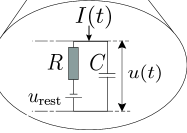

The neurons are represented by an RC circuit, with a current $I(t)$ incoming in one side, and a rest tension $u_{rest}$ on the other side. The capacitor as constant $C$ and the resistor $R$. Each emmited spike correspond to a negative incoming current in the capacitor $I_r$. Thus, denoting $\hat{u} = u(t) - u_{rest}$, we have:

$$\tau_m \frac{d\hat{u}}{dt} = -\hat{u} + R(I(t) + I_r(t))$$
with $$I_r(t) = -C(V_{th} - u_{ref})\sum_{t^{(f)}<t}\delta(t - t^{(f)})$$
where $t^{(f)}$ are the spiking times.


Exact solution is given by:
$$u(t) = u_{rest}.(1-exp(-\frac{t}{\tau_m})) + V_m.exp(-\frac{t}{\tau_m}) + (V_{th} - u_{ref}).\sum_{t^{(f)}<t}exp(-\frac{t-t^{(f)}}{\tau_m}) + \frac{1}{C}\int_o^tI(s)exp(-\frac{t-s}{\tau_m})ds$$

With $V_m$ the initial potential of the membrane, $V_{th}$ the spiking threshold and $u_{ref}$ the potential just after the spiking.

## Discretization
taking $u_{rest}= u_{ref} = 0$, we can derive from the above formula the following numerical scheme:

* input of neuron i at layer n at time t+1
$$x^{t+1, n}_i = \sum_{j=1}^{l(n-1)} w_{i,j}^n.o_j^{t+1,n-1}$$
which is:
$$X^{t+1,n}=W^nO^{t+1,n-1}$$

* voltage of neuron i of layer n at time t+1
$$u_i^{t+1, n}= (1-\frac{\Delta t}{\tau_m})u_i^{t, n}+x_i^{t+1, n} - V_{th}o_i^{t,n}$$
which is:
$$U^{t+1,n} = (1-\frac{\Delta t}{\tau_m})U^{t,n} + X^{t+1, n} - V_{th}O^{t,n}$$

* output of neuron i of the layer n at time t+1
$$o_i^{t+1, n} = g(u_i^{t+1, n})$$
which is :
$$O^{t+1, n}=g(U^{t+1, n})$$

with $g(t) = \mathbb{1}_{t\geqslant V_{th}}$

### Notations
* $U\odot V$ is the componentwise product 
* $M^\star$ is the transpose matrix of $M$
* $V_{th}$ is the threshold potential
* $\frac{\partial L}{\partial o_i^{t,n}} = \delta_i^{t,n}$ and $\frac{\partial L}{\partial u_i^{t,n}} = \varepsilon_i^{t,n}$
with
$$ L = \frac{1}{2S}\sum_{s=1}^S\|Y_s - \frac{1}{T}\sum_{t=1}^T O_s^{t,N}\|^2_2$$
* $\tau_m$ is the cicruit time constant, recall that $\tau_m = RC$
* $\Delta t$ is the simulation time step as well as a spike duration

# Derivatives

### case $t=T$ and $n=N$

$$\delta_i^{T,N} = - \frac{1}{TS}(y_i - \frac{1}{T}\sum_{k=1}^To_i^{k,N})$$
and 
$$\varepsilon_i^{T,N} = \delta_i^{T,N}.\frac{\partial g}{\partial u_i^{T,N}}$$

so in vector notations:

$$\Delta^{T,N} = -\frac{1}{TS}(Y - \frac{1}{T}\sum_{t=1}^TO^{t,N})$$
and
$$E^{T,N} = \Delta^{T,N} \odot \frac{\partial g}{\partial U^{T,N}}$$

### case $t=T$ and $n < N$

$$\delta_i^{T,n} = \sum_{j=1}^{l(n+1)}\delta_j^{T,n+1}.w_{ji}^{n+1}.\frac{\partial g}{\partial u_j^{T,n+1}}$$
and 
$$\varepsilon_i^{T,n} = \delta_i^{T,n}.\frac{\partial g}{\partial u_i^{T,n}}$$

so in vector notations:

$$\Delta^{T,n} = (W^{n+1})^\star(\Delta^{T,n+1}\odot \frac{\partial g}{\partial U^{T,n+1}})$$
and
$$E^{T,n} = \Delta^{T,n} \odot \frac{\partial g}{\partial U^{T,n}}$$

### case $t<T$ and $n=N$

$$\delta_i^{t,N} = \delta_i^{T,N} - V_{th}.\delta_i^{t+1,N}.\frac{\partial g}{\partial u_i^{t+1,N}}$$

and 

$$\varepsilon_i^{t,N} = \delta_i^{t,N}.\frac{\partial g}{\partial u_i^{t,N}} + (1 - \frac{\Delta t}{\tau_m}).\varepsilon_i^{t+1,N}$$

so in vector notations:
$$\Delta^{t,N} = \Delta^{T,N} - V_{th}. \Delta^{t+1,N}\odot \frac{\partial g}{\partial U^{t+1,N}}$$
and
$$E^{t,N} = \Delta^{t,N}\odot \frac{\partial g}{\partial U^{t,N}} + (1 - \frac{\Delta t}{\tau_m}).E^{t+1,N}$$

### case $t<T$ and $n<N$
$$\delta_i^{t,n} = \sum_{j=1}^{l(n+1)}\delta_j^{t,n+1}.w_{ji}^{n+1}.\frac{\partial g}{\partial u_j^{t,n+1}} - V_{th} .\delta_i^{t+1,n}.\frac{\partial g}{\partial u_i^{t+1,n}}$$
and
$$\varepsilon_i^{t,n} = \delta_i^{t,n}.\frac{\partial g}{\partial u_i^{t,n}} + (1 - \frac{\Delta t}{\tau_m}).\varepsilon_i^{t+1,n}$$

so in vector notations:

$$\Delta^{t,n} = (W^{n+1})^\star(\Delta^{t,n+1} \odot \frac{\partial g}{\partial U^{t, n+1}}) - V_{th}. \Delta^{t+1,n}\odot \frac{\partial g}{\partial U^{t+1,n}}$$

and

$$E^{t,n} = \Delta^{t,n}\odot \frac{\partial g}{\partial U^{t,n}} + (1 - \frac{\Delta t}{\tau_m}).E^{t+1,n}$$

### Derivative of W

$$\frac{\partial L}{\partial W^n} = \sum_{t=1}^T\frac{\partial L}{\partial U^{t,n}}.(O^{t, n-1})^\star = \sum_{t=1}^TE^{t,n}.(O^{t, n-1})^\star$$